# Drzewa decyzyjne

### Główne hiperparametry
* Kryterium podziału
    - Gini
    - Information Gain ("entropy")
* Maksymalna głębokość ("max_depth")
* Minimalna wielkość dzielonego zbioru ("min_samples_split" - minsplit w rpart)
* Minimalna wielkość zbioru w liściu ("min_samples_leaf" - minbucket w rpart)

In [18]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
import numpy as np
import pandas_profiling as pp
%matplotlib inline
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image, display, HTML

plt.rcParams['figure.figsize']=25,11
plt.style.use('seaborn-whitegrid')

display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
title_reference_dict = {'Mr.':'Mr.',
                        'Mrs.':'Mrs.',
                        'Miss.':'Miss.',
                        'Master.':'Master.',
                        'Don.':'Other', 
                        'Rev.':'Other',
                        'Dr.':'Other',
                        'Mme.':'Other',
                        'Ms.':'Other',
                        'Major.':'Other',
                        'Lady.':'Other',
                        'Sir.':'Other',
                        'Mlle.':'Other',
                        'Col.':'Other', 
                        'Capt.':'Other', 
                        'the':'Other',
                        'Jonkheer.':'Other'}

titanic_df = pd.read_csv("titanic.csv")
titanic_df.loc[:,"Title"] = titanic_df.Name.str.split(" ").apply(lambda x: x[0])
titanic_df.loc[:,"Title"] = titanic_df.Title.apply(lambda x: title_reference_dict[x])
titanic_df.drop("Name",axis=1,inplace=True)
titanic_df = pd.get_dummies(titanic_df, drop_first=True)

# Charakterystyka zbioru titanic + podstawowy feature engineering

* One Hot Encoding na płci i tytule (Mr., Mrs., Miss., Master., Other)
* Drzewa są odporne na różnice rzędu wielkości w danych - brak potrzeby standaryzacji

In [20]:
pp.ProfileReport(titanic_df)

Number of variables,11
Number of observations,887
Total Missing (%),0.0%
Total size in memory,46.0 KiB
Average record size in memory,53.1 B
Numeric,5
Categorical,0
Boolean,6
Date,0
Text (Unique),0
Rejected,0


In [4]:
scores_df = pd.DataFrame({"Accuracy":[],"Precision":[],"Recall":[],"F1_score":[]})
params_df = pd.DataFrame({"Criterion":[],"Max_depth":[],"Min_samples_split":[],"Min_samples_leaf":[]})
X, y = titanic_df.drop('Survived', axis=1), titanic_df.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

def make_score_row(y_test, y_pred, name):
    return pd.DataFrame(
        {"Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1_score": f1_score(y_test, y_pred)}, index=[name])

def make_param_row(estimator, name):
    params = estimator.get_params()
    return pd.DataFrame(
        {"Criterion": params["criterion"],
        "Max_depth": params["max_depth"],
        "Min_samples_split": params["min_samples_split"],
        "Min_samples_leaf": params["min_samples_leaf"]
        }, index=[name])

## Domyślne hiperparametry
* Kryterium podziału - Gini
* Maksymalna głębokość - brak
* Minimalna wielkość dzielonego zbioru - 2
* Minimalna wielkość zbioru w liściu - 1

In [5]:
default_tree = DecisionTreeClassifier()
default_tree.fit(X_train, y_train)
y_pred = default_tree.predict(X_test)
scores_df = scores_df.append(make_score_row(y_test, y_pred, "Default"), ignore_index=False)
params_df = params_df.append(make_param_row(default_tree, "Default"), ignore_index=False)

## Hiperparametry zaproponowane w pracy
* Kryterium podziału - porównam Gini i Information Gain ("entropy")
* Maksymalna głębokość - 21
* Minimalna wielkość dzielonego zbioru - 24
* Minimalna wielkość zbioru w liściu - 12

In [6]:
benchmarked_tree = DecisionTreeClassifier(max_depth=21,
                                          min_samples_split=24,
                                          min_samples_leaf=12)
benchmarked_tree.fit(X_train, y_train)
y_pred = benchmarked_tree.predict(X_test)
scores_df = scores_df.append(make_score_row(y_test, y_pred, "Benchmarked"), ignore_index=False)
params_df = params_df.append(make_param_row(benchmarked_tree, "Benchmarked"), ignore_index=False)

In [7]:
benchmarked_tree_info_gain = DecisionTreeClassifier(criterion="entropy",
                                          max_depth=21,
                                          min_samples_split=24,
                                          min_samples_leaf=12)
benchmarked_tree_info_gain.fit(X_train, y_train)
y_pred = benchmarked_tree_info_gain.predict(X_test)
scores_df = scores_df.append(make_score_row(y_test, y_pred, "BenchmarkedWithInfoGain"), ignore_index=False)
params_df = params_df.append(make_param_row(benchmarked_tree_info_gain, "BenchmarkedWithInfoGain"), ignore_index=False)

## Random Search
* Kryterium podziału - Gini
* Maksymalna głębokość w $\{1,2,\dots, 30\}$
* Minimalna wielkość dzielonego zbioru  w$\{2,3,\dots, 60\}$
* Minimalna wielkość zbioru w liściu w $\{1,2,\dots, 60\}$

In [8]:
param_distributions = {
    "max_depth": np.arange(1, 31),
    "min_samples_split": np.arange(2,61),
    "min_samples_leaf": np.arange(1,61)
}

cv_tree = RandomizedSearchCV(DecisionTreeClassifier(), 
                             param_distributions=param_distributions, 
                             cv=5, 
                             n_iter=10000,
                             random_state=42)
cv_tree.fit(X_train, y_train)
trained_classifier = cv_tree.best_estimator_
y_pred = cv_tree.predict(X_test)
scores_df = scores_df.append(make_score_row(y_test, y_pred, "RandomSearch"), ignore_index=False)
params_df = params_df.append(make_param_row(trained_classifier, "RandomSearch"), ignore_index=False)

In [9]:
params_df

,Criterion,Max_depth,Min_samples_split,Min_samples_leaf
Default,gini,None,2.0,1.0
Benchmarked,gini,21,24.0,12.0
BenchmarkedWithInfoGain,entropy,21,24.0,12.0
RandomSearch,gini,4,27.0,16.0


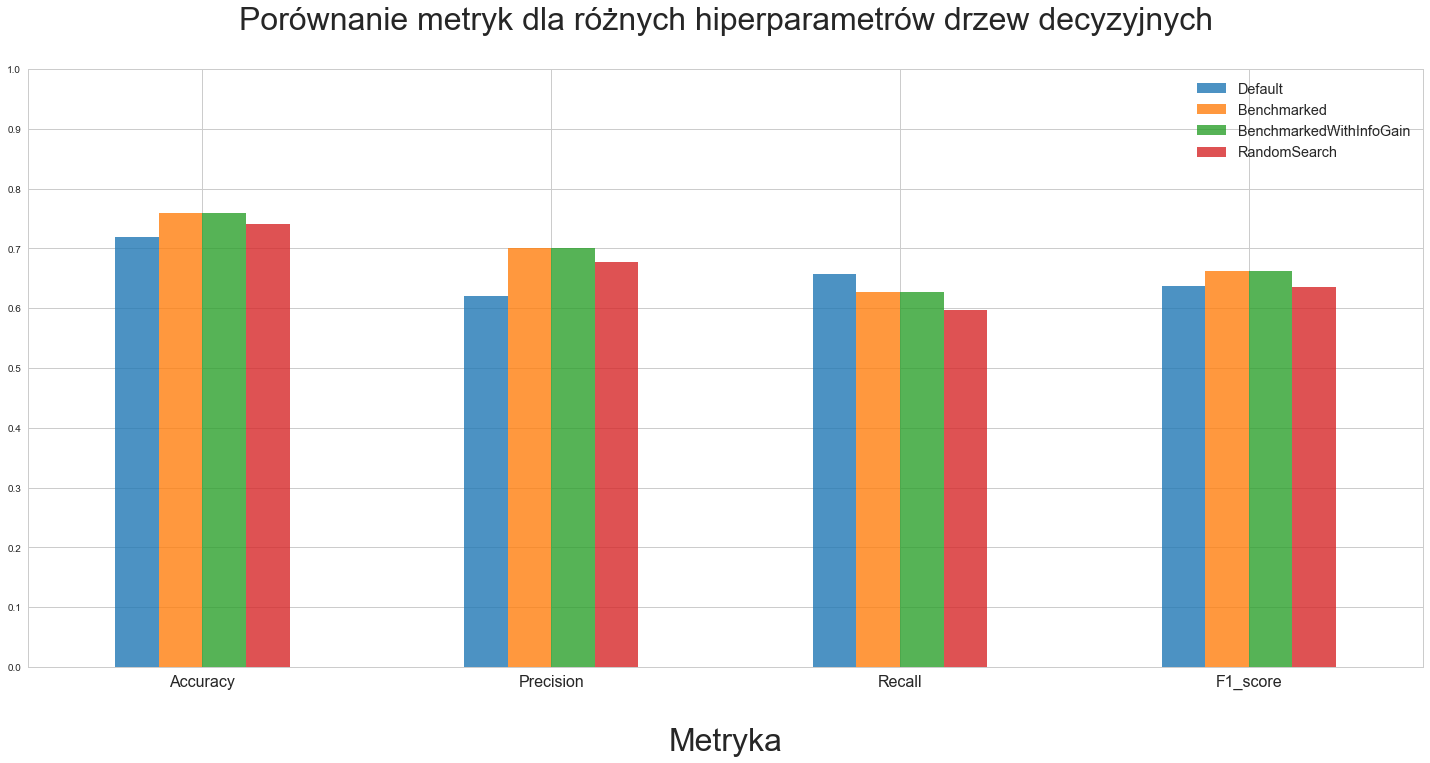

In [19]:
scores_df.transpose().plot(kind="bar", alpha = 0.8)
plt.title("Porównanie metryk dla różnych hiperparametrów drzew decyzyjnych\n", size=32)
plt.xticks(size=16,rotation=0)
plt.xlabel("\nMetryka", size=32)
plt.legend(fontsize='x-large')
plt.yticks(np.linspace(0,1,11))
plt.show()

# Wizualizacje drzewa decyzyjnych

## Random Search

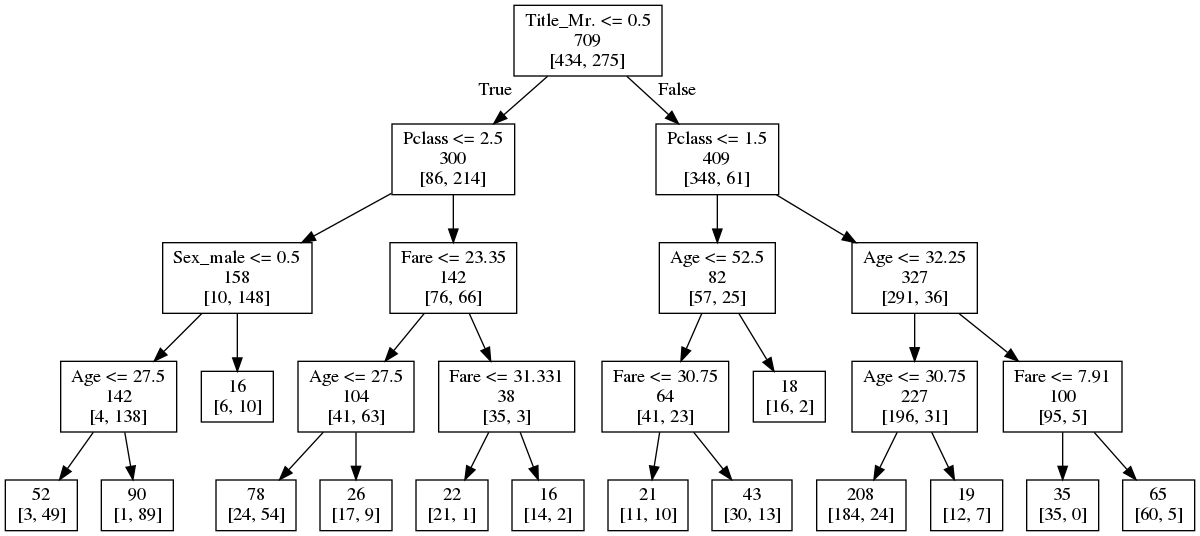

In [11]:
export_graphviz(trained_classifier,out_file='rscv.dot', feature_names=X_train.columns, label=None, impurity=False)
! dot -Tpng rscv.dot -o rscv.png 
figure = Image(filename='rscv.png')
display(figure)

## Benchmark z pracy

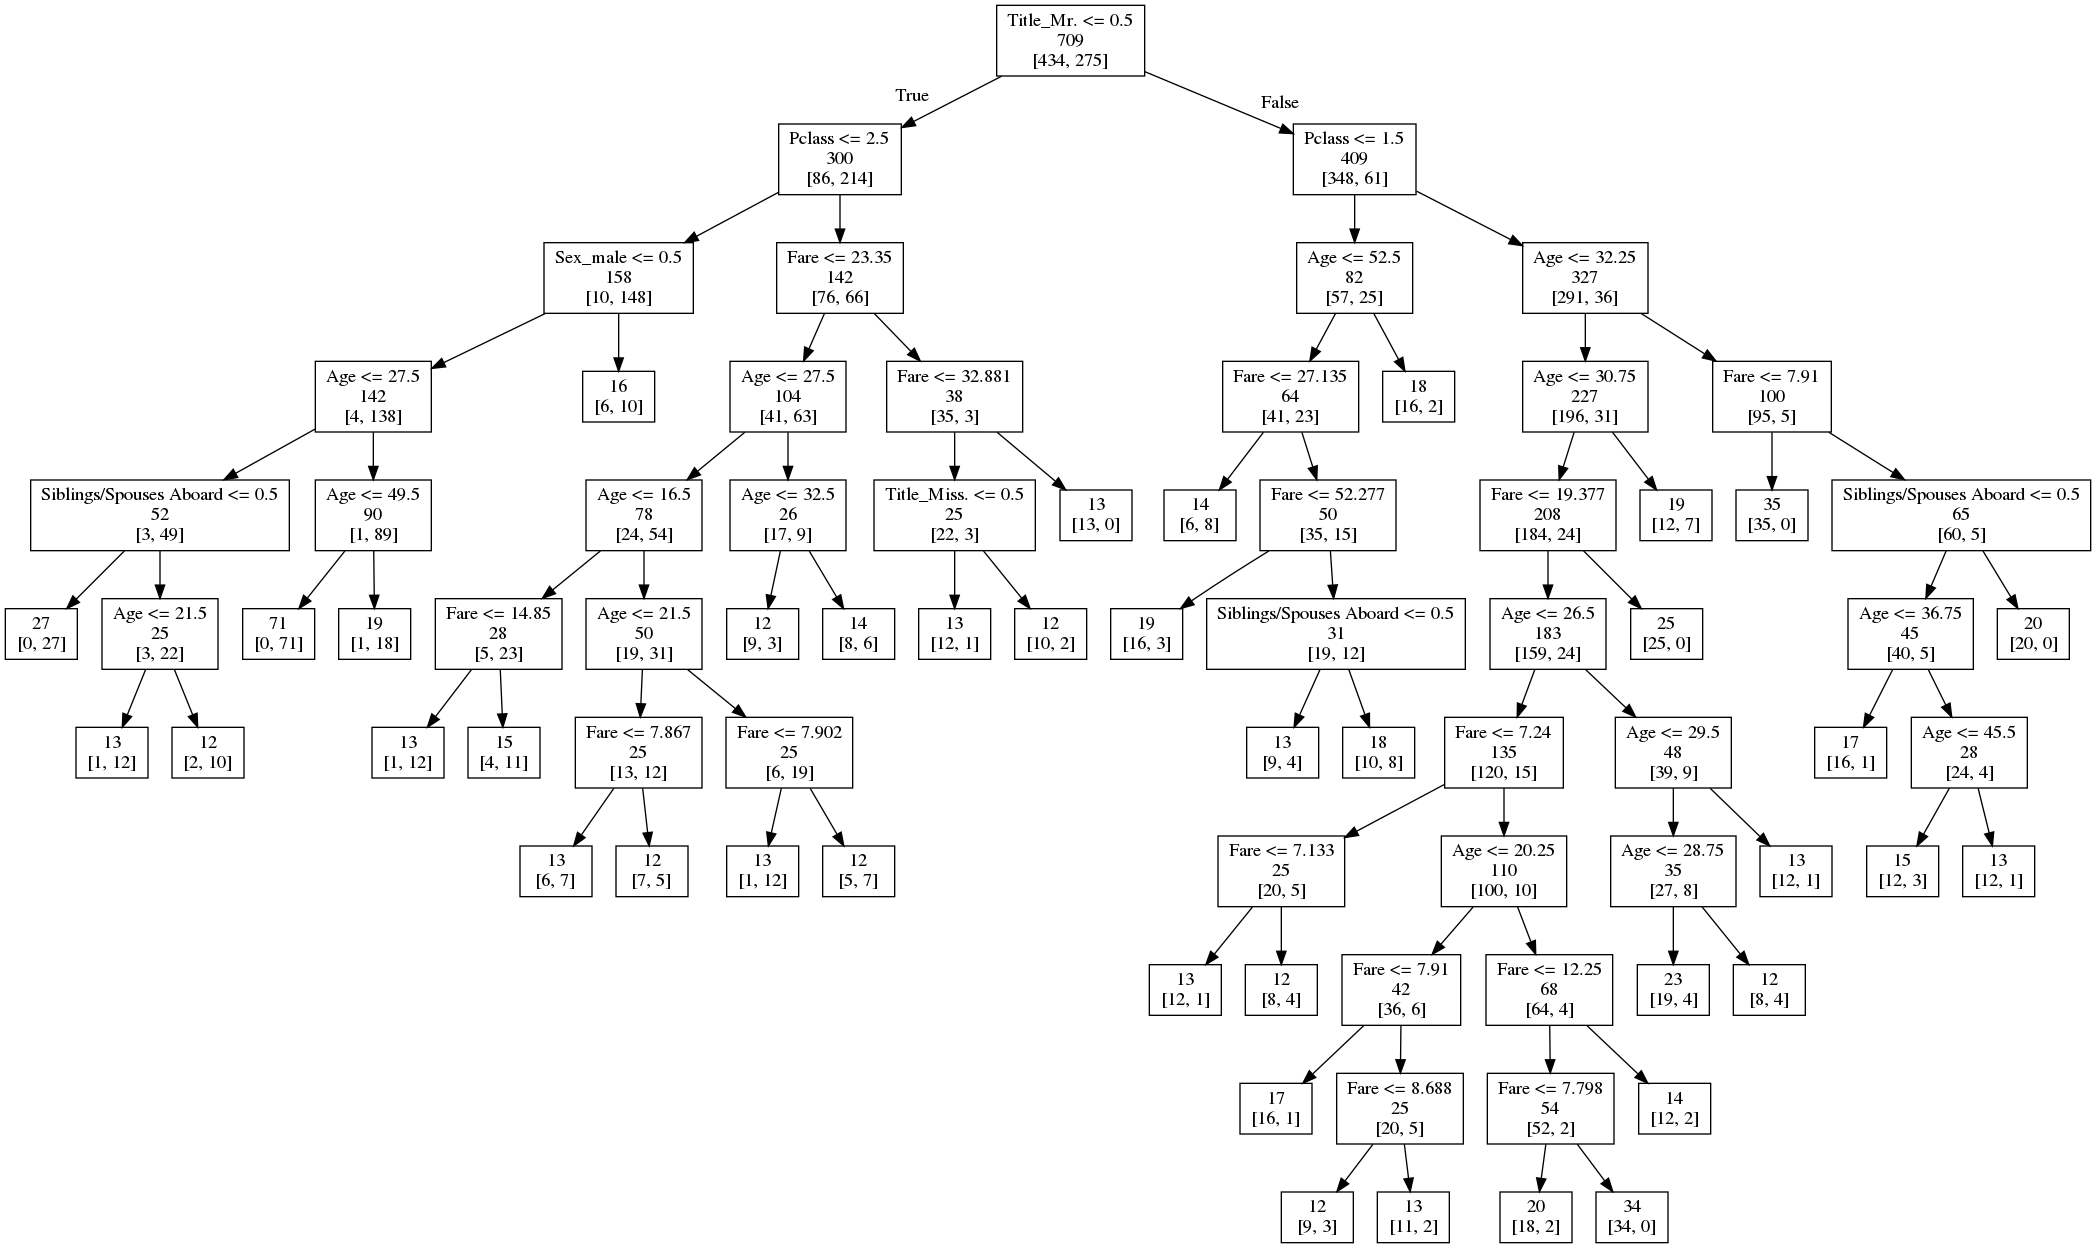

In [12]:
export_graphviz(benchmarked_tree,out_file='benchmarked.dot', feature_names=X_train.columns, label=None, impurity=False)
! dot -Tpng benchmarked.dot -o benchmarked.png 
figure = Image(filename='benchmarked.png')
display(figure)

## Wartości domyślne

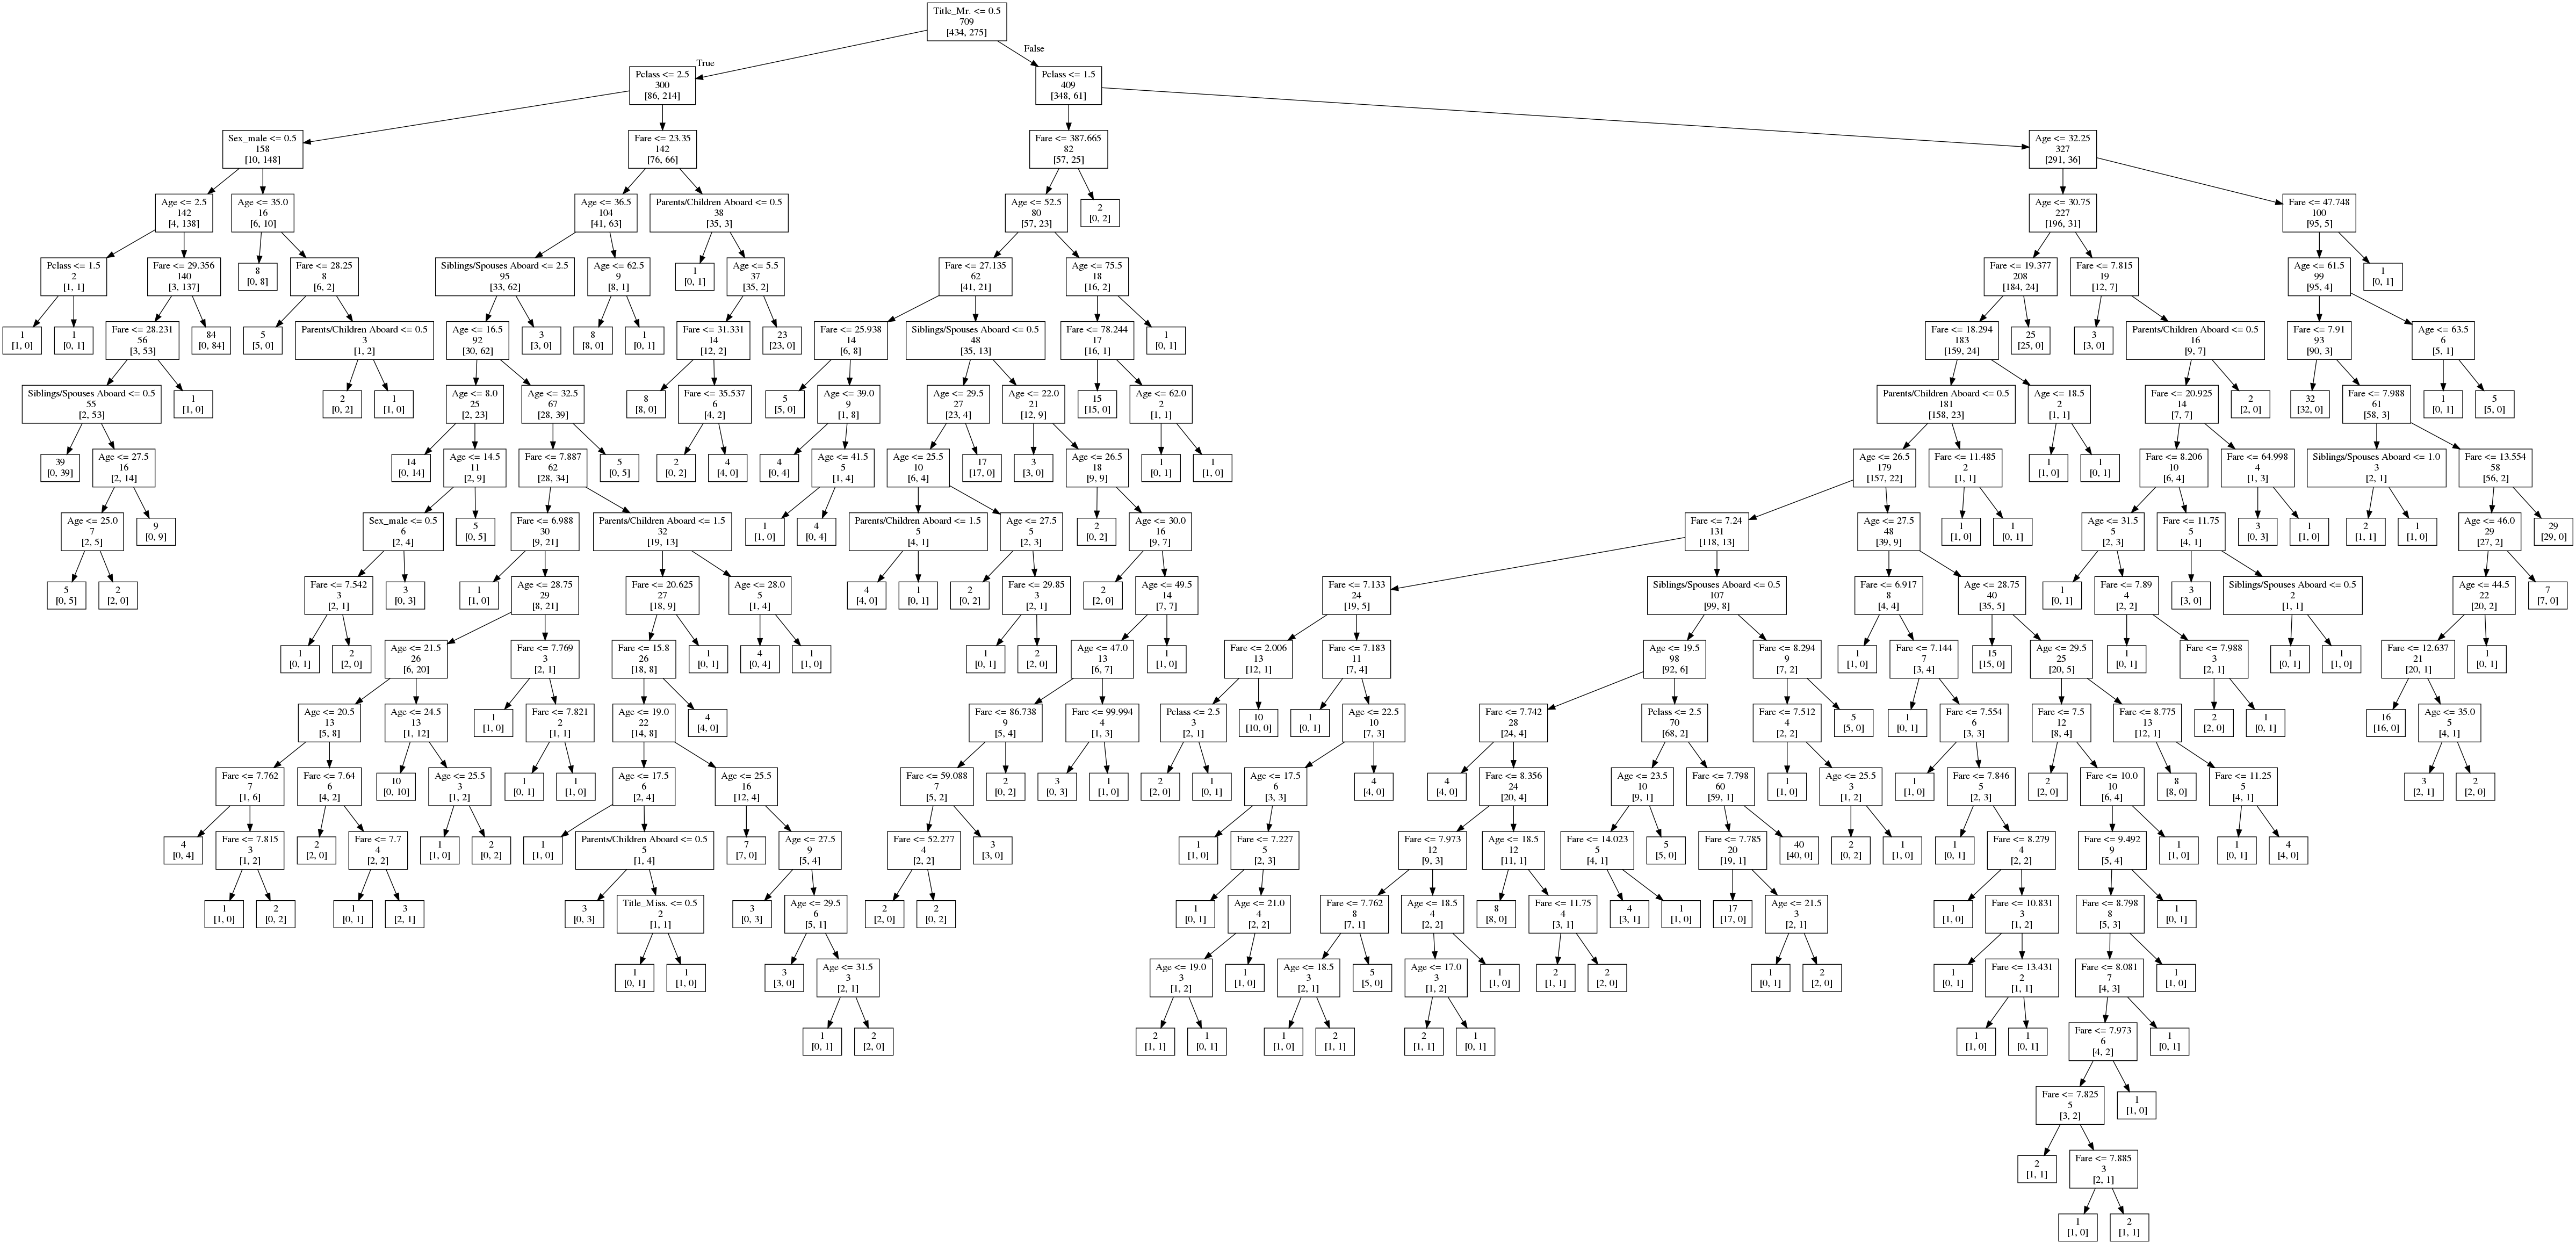

In [13]:
export_graphviz(default_tree,out_file='default.dot', feature_names=X_train.columns, label=None, impurity=False)
! dot -Tpng default.dot -o default.png 
figure = Image(filename='default.png')
display(figure)

# Wnioski

## Manipulacja hiperparametrami
* Wzrost wartości Max_depth zwiększa model complexity
* Wzrost wartości Min_samples_split i Min_samples_leaf zmniejsza model complexity
* Zmiana kryterium Gini na Information Gain nie spowodowała żadnej zmiany - w większości przypadków mogę być one równoważne

## Porównanie drzew
* Wartości domyślne pakietu powodują znaczne przeuczenie się modelu
* Wartości domyślne pochodzące z pracy dają najlepsze wyniki, random search czasami znajduje lepszy zestaw parametrów, ale przy losowych podziałach na zbiór treningowy i testowy lepiej radzą sobie parametry z pracy.